In [1]:
# Cell 1: Import libraries and load data


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
np.random.seed(42)

# Load dataset
df = pd.read_csv("loan.csv")

# Preview structure
print("📦 Dataset Loaded: loan.csv")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")

print("\n🧬 Column Types:")
print(df.dtypes)

print("\n🔍 Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

print("\n📌 Sample Rows:")
display(df.head())


📦 Dataset Loaded: loan.csv
Shape: 614 rows, 13 columns

🧬 Column Types:
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

🔍 Missing Values:
Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

📌 Sample Rows:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


First 5 rows of the dataset:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural      

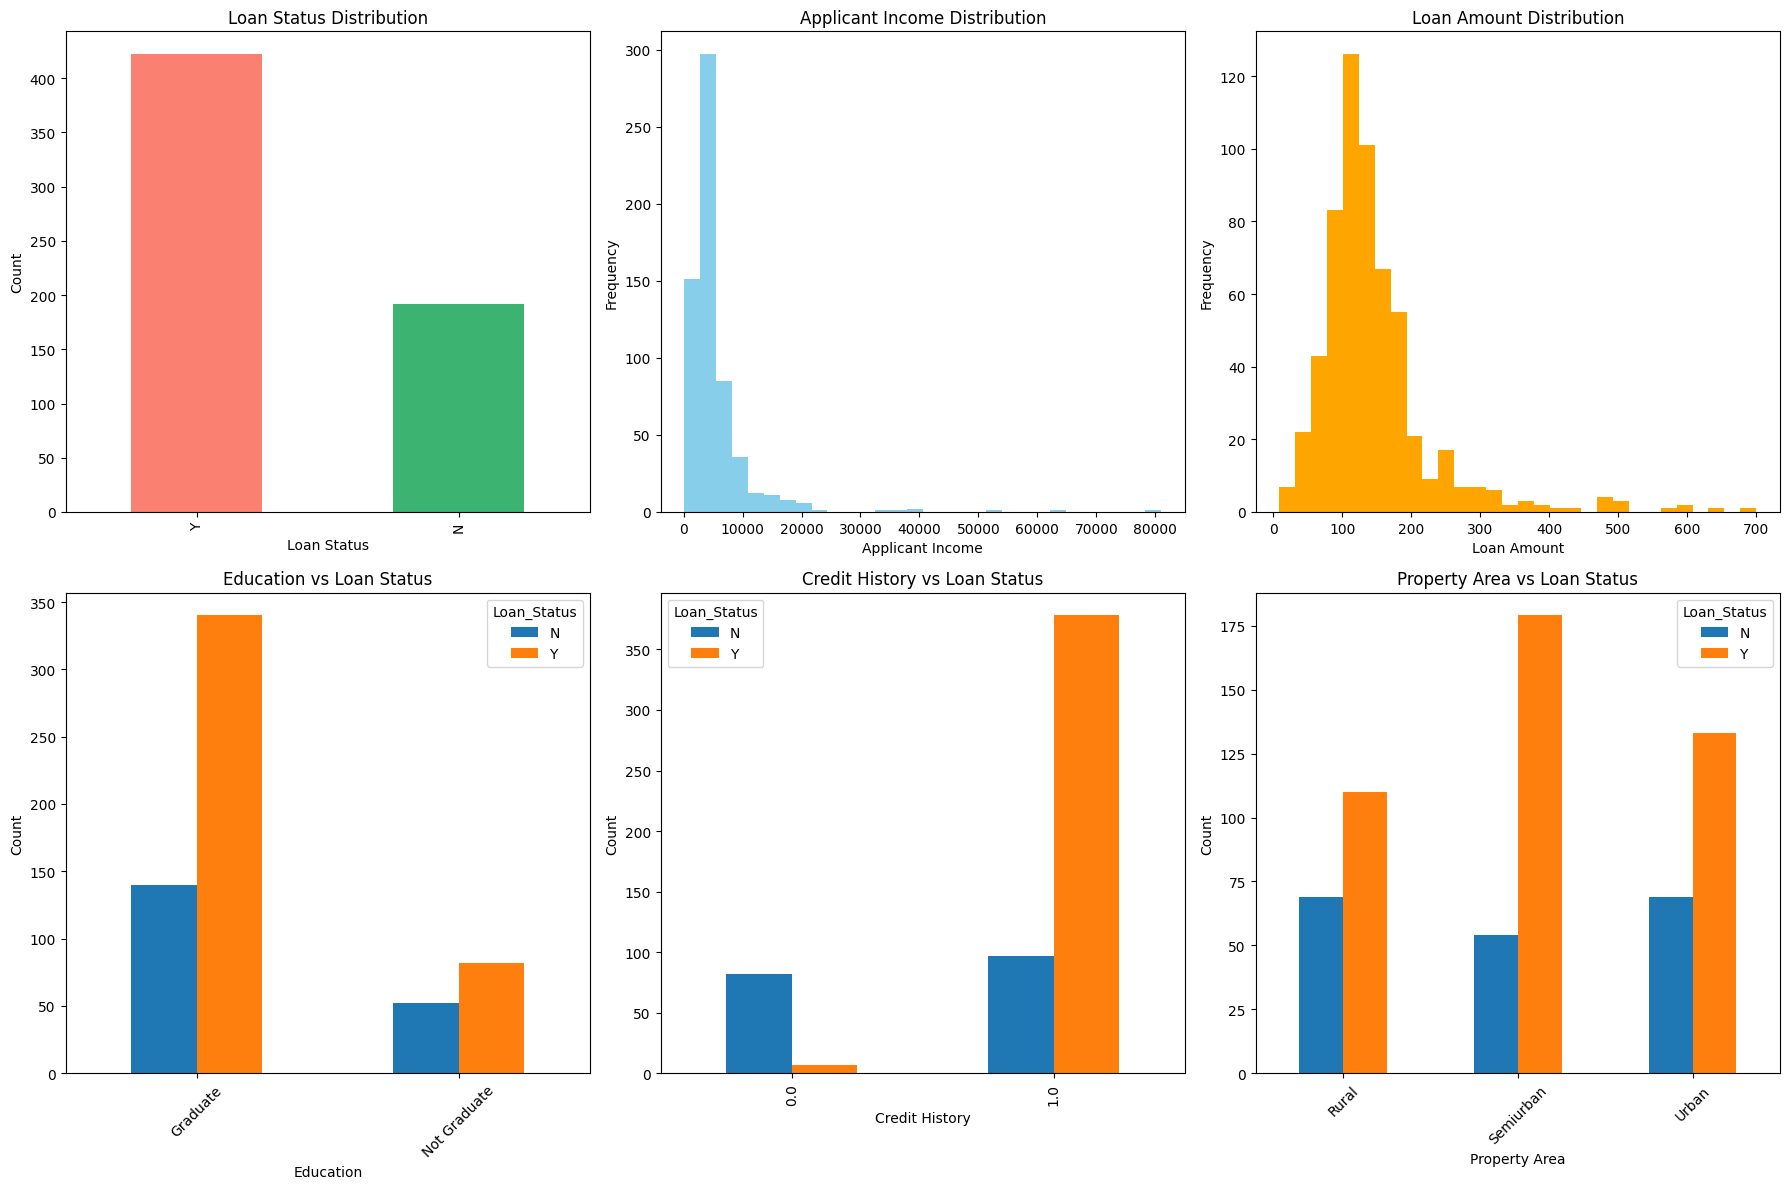

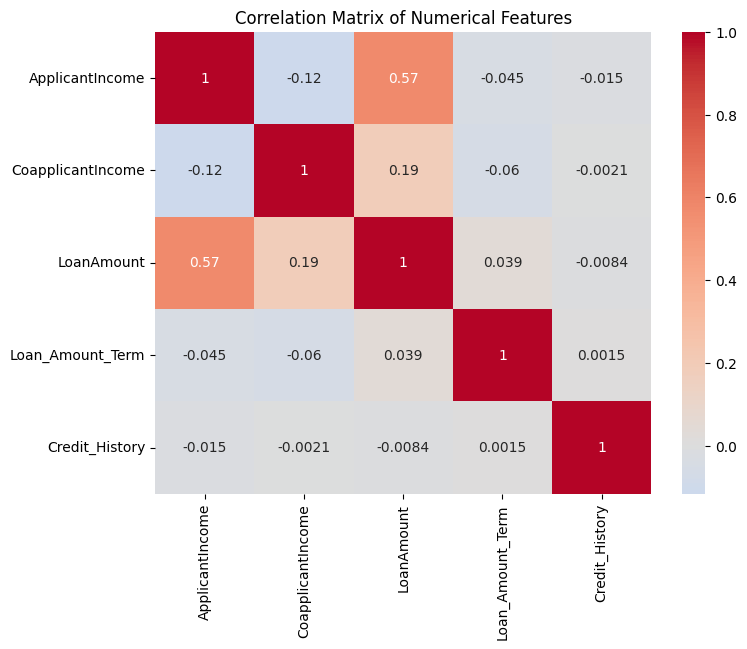

In [2]:
# Display first few rows
print("First 5 rows of the dataset:")
print(df.head())

print("\nDataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget variable distribution:")
print(df['Loan_Status'].value_counts())
print(f"Approval rate: {df['Loan_Status'].value_counts()['Y'] / len(df) * 100:.2f}%")

# Statistical summary
print("\nNumerical features summary:")
print(df.describe())

# Visualizations
plt.figure(figsize=(18, 12))

# Loan Status Distribution
plt.subplot(2, 3, 1)
df['Loan_Status'].value_counts().plot(kind='bar', color=['salmon', 'mediumseagreen'])
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')

# Applicant Income
plt.subplot(2, 3, 2)
plt.hist(df['ApplicantIncome'], bins=30, color='skyblue')
plt.title('Applicant Income Distribution')
plt.xlabel('Applicant Income')
plt.ylabel('Frequency')

# Loan Amount
plt.subplot(2, 3, 3)
plt.hist(df['LoanAmount'].dropna(), bins=30, color='orange')
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')

# Education vs Loan Status
plt.subplot(2, 3, 4)
pd.crosstab(df['Education'], df['Loan_Status']).plot(kind='bar', ax=plt.gca())
plt.title('Education vs Loan Status')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Credit History vs Loan Status
plt.subplot(2, 3, 5)
pd.crosstab(df['Credit_History'], df['Loan_Status']).plot(kind='bar', ax=plt.gca())
plt.title('Credit History vs Loan Status')
plt.xlabel('Credit History')
plt.ylabel('Count')

# Property Area vs Loan Status
plt.subplot(2, 3, 6)
pd.crosstab(df['Property_Area'], df['Loan_Status']).plot(kind='bar', ax=plt.gca())
plt.title('Property Area vs Loan Status')
plt.xlabel('Property Area')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Correlation heatmap
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [3]:
# Create a copy for preprocessing
df_processed = df.copy()
print("🔧 Starting data preprocessing...")

# Handle missing values
print("\n🧹 Handling missing values...")

# Fill missing categorical values with mode
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
for col in categorical_columns:
    if df_processed[col].isnull().sum() > 0:
        mode_val = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in '{col}' with mode: {mode_val}")

# Fill numerical values with median
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
for col in numerical_columns:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median: {median_val}")

# Fill Credit_History with mode
if df_processed['Credit_History'].isnull().sum() > 0:
    credit_mode = df_processed['Credit_History'].mode()[0]
    df_processed['Credit_History'].fillna(credit_mode, inplace=True)
    print(f"Filled missing values in 'Credit_History' with mode: {credit_mode}")

print("\n✅ Missing values after preprocessing:")
print(df_processed.isnull().sum())

# Feature engineering
print("\n🧠 Performing feature engineering...")

# Total income
df_processed['TotalIncome'] = df_processed['ApplicantIncome'] + df_processed['CoapplicantIncome']

# Loan amount to income ratio
df_processed['LoanAmountToIncome'] = df_processed['LoanAmount'] / df_processed['TotalIncome']

# Convert Dependents to numeric
df_processed['Dependents_num'] = df_processed['Dependents'].replace('3+', 3).astype(int)
df_processed['IncomePerDependent'] = df_processed['TotalIncome'] / (df_processed['Dependents_num'] + 1)

# Log transformations for skewed features
df_processed['ApplicantIncome_log'] = np.log1p(df_processed['ApplicantIncome'])
df_processed['TotalIncome_log'] = np.log1p(df_processed['TotalIncome'])
df_processed['LoanAmount_log'] = np.log1p(df_processed['LoanAmount'])

print("\n🆕 New features created:")
print("- TotalIncome")
print("- LoanAmountToIncome")
print("- IncomePerDependent")
print("- Log-transformed income and loan amount")

# Encode categorical variables
print("\n🔠 Encoding categorical variables...")
label_encoders = {}
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

for feature in categorical_features:
    le = LabelEncoder()
    df_processed[feature + '_encoded'] = le.fit_transform(df_processed[feature])
    label_encoders[feature] = le
    print(f"Encoded '{feature}' → '{feature}_encoded'")

# Prepare feature set
feature_columns = [
    'Gender_encoded', 'Married_encoded', 'Dependents_encoded', 'Education_encoded', 
    'Self_Employed_encoded', 'Property_Area_encoded', 'ApplicantIncome', 'CoapplicantIncome',
    'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 
    'LoanAmountToIncome', 'IncomePerDependent', 'ApplicantIncome_log', 
    'TotalIncome_log', 'LoanAmount_log'
]
X = df_processed[feature_columns]

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(df_processed['Loan_Status'])

print(f"\n🧾 Feature matrix shape: {X.shape}")
print(f"🎯 Target vector shape: {y.shape}")
print(f"✅ Target classes: {le_target.classes_}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\n📊 Training set size: {X_train.shape}")
print(f"📊 Test set size: {X_test.shape}")

# Scale numerical features
print("\n📏 Scaling numerical features...")
scaler = StandardScaler()
num_cols_to_scale = [
    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 
    'TotalIncome', 'LoanAmountToIncome', 'IncomePerDependent',
    'ApplicantIncome_log', 'TotalIncome_log', 'LoanAmount_log'
]
num_indices = [X.columns.get_loc(col) for col in num_cols_to_scale]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled.iloc[:, num_indices] = scaler.fit_transform(X_train.iloc[:, num_indices])
X_test_scaled.iloc[:, num_indices] = scaler.transform(X_test.iloc[:, num_indices])

print("✅ Feature scaling completed.")


🔧 Starting data preprocessing...

🧹 Handling missing values...
Filled missing values in 'Gender' with mode: Male
Filled missing values in 'Married' with mode: Yes
Filled missing values in 'Dependents' with mode: 0
Filled missing values in 'Self_Employed' with mode: No
Filled missing values in 'LoanAmount' with median: 128.0
Filled missing values in 'Loan_Amount_Term' with median: 360.0
Filled missing values in 'Credit_History' with mode: 1.0

✅ Missing values after preprocessing:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

🧠 Performing feature engineering...

🆕 New features created:
- TotalIncome
- LoanAmountToIncome
- IncomePerDependent
- Log-transformed income and loan amount

🔠 Encoding categorical variables...
Encoded


🔍 Training: Logistic Regression
✅ Accuracy: 0.8537
🎯 ROC-AUC Score: 0.8053
📊 Confusion Matrix:
[[23 15]
 [ 3 82]]

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        38
           1       0.85      0.96      0.90        85

    accuracy                           0.85       123
   macro avg       0.86      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123


🔍 Training: Random Forest
✅ Accuracy: 0.8130
🎯 ROC-AUC Score: 0.8381
📊 Confusion Matrix:
[[24 14]
 [ 9 76]]

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.63      0.68        38
           1       0.84      0.89      0.87        85

    accuracy                           0.81       123
   macro avg       0.79      0.76      0.77       123
weighted avg       0.81      0.81      0.81       123


🔍 Training: Gradient Boosting
✅ Accuracy: 0.8130
🎯 ROC-AUC Score: 0.8

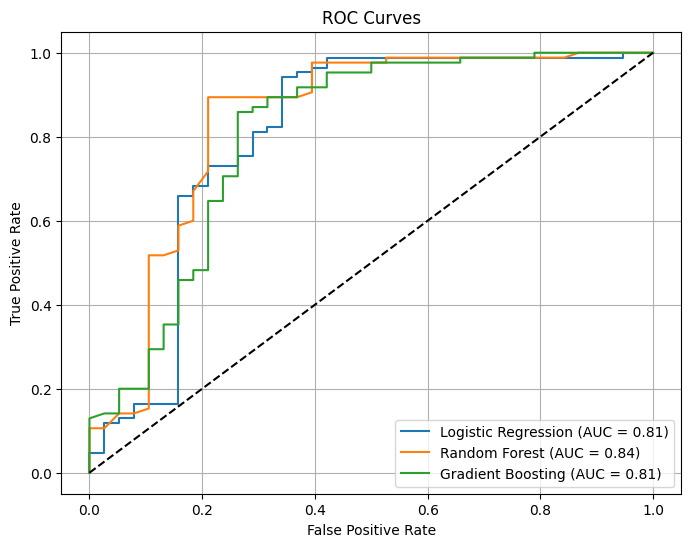

In [4]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n🔍 Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"🎯 ROC-AUC Score: {roc_auc:.4f}")
    print("📊 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n📝 Classification Report:")
    print(classification_report(y_test, y_pred))

# Optional: Plot ROC curves
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

# Containers for results and models
model_results = {}
trained_models = {}

print("🏁 Training and evaluating multiple ML models...\n")

# Loop through each model
for name, model in models.items():
    print(f"🔄 Training: {name}")
    
    # Use scaled data for SVM and Logistic Regression
    if name in ['SVM', 'Logistic Regression']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Ensure no missing values
    if X_train_model.isnull().sum().sum() > 0 or X_test_model.isnull().sum().sum() > 0:
        print("⚠️ Missing values detected. Filling with median...")
        X_train_model.fillna(X_train_model.median(), inplace=True)
        X_test_model.fillna(X_test_model.median(), inplace=True)
    
    # Fit model
    model.fit(X_train_model, y_train)
    trained_models[name] = model

    # Predict
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    cv_scores = cross_val_score(model, X_train_model, y_train, cv=5, scoring='accuracy')

    # Store results
    model_results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"✅ {name} Results:")
    print(f"   - Accuracy:  {accuracy:.4f}")
    print(f"   - ROC AUC:   {roc_auc:.4f}")
    print(f"   - CV Score:  {cv_scores.mean():.4f} ± {cv_scores.std() * 2:.4f}\n")

# Summary DataFrame
print("📋 Model Comparison Summary")
print("-" * 60)
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [res['accuracy'] for res in model_results.values()],
    'ROC-AUC': [res['roc_auc'] for res in model_results.values()],
    'CV Mean': [res['cv_mean'] for res in model_results.values()],
    'CV Std': [res['cv_std'] for res in model_results.values()]
})

print(results_df.to_string(index=False))

# Best model based on Accuracy
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model = trained_models[best_model_name]
print(f"\n🏆 Best Performing Model: {best_model_name}")


🏁 Training and evaluating multiple ML models...

🔄 Training: Logistic Regression
✅ Logistic Regression Results:
   - Accuracy:  0.8537
   - ROC AUC:   0.8201
   - CV Score:  0.7943 ± 0.0272

🔄 Training: Random Forest
✅ Random Forest Results:
   - Accuracy:  0.8130
   - ROC AUC:   0.8381
   - CV Score:  0.7719 ± 0.0686

🔄 Training: Gradient Boosting
✅ Gradient Boosting Results:
   - Accuracy:  0.8130
   - ROC AUC:   0.8060
   - CV Score:  0.7597 ± 0.0528

🔄 Training: SVM
✅ SVM Results:
   - Accuracy:  0.6911
   - ROC AUC:   0.1536
   - CV Score:  0.6864 ± 0.0079

📋 Model Comparison Summary
------------------------------------------------------------
              Model  Accuracy  ROC-AUC  CV Mean   CV Std
Logistic Regression  0.853659 0.820124 0.794290 0.013624
      Random Forest  0.813008 0.838080 0.771923 0.034293
  Gradient Boosting  0.813008 0.806037 0.759658 0.026421
                SVM  0.691057 0.153560 0.686353 0.003960

🏆 Best Performing Model: Logistic Regression


Detailed Evaluation of Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           N       0.92      0.58      0.71        38
           Y       0.84      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.88      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123



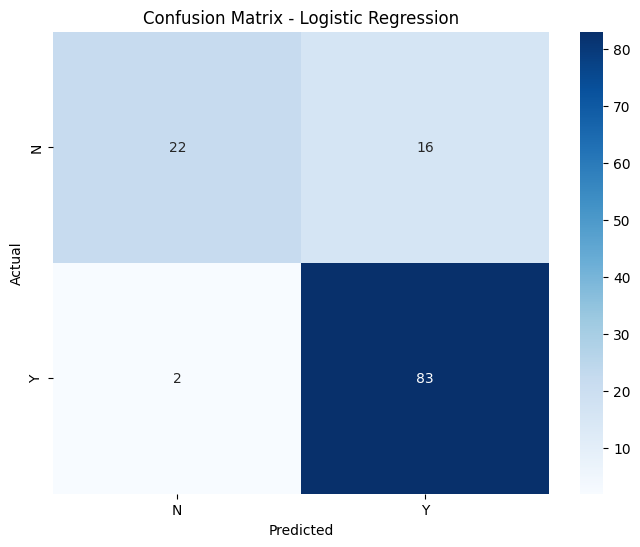

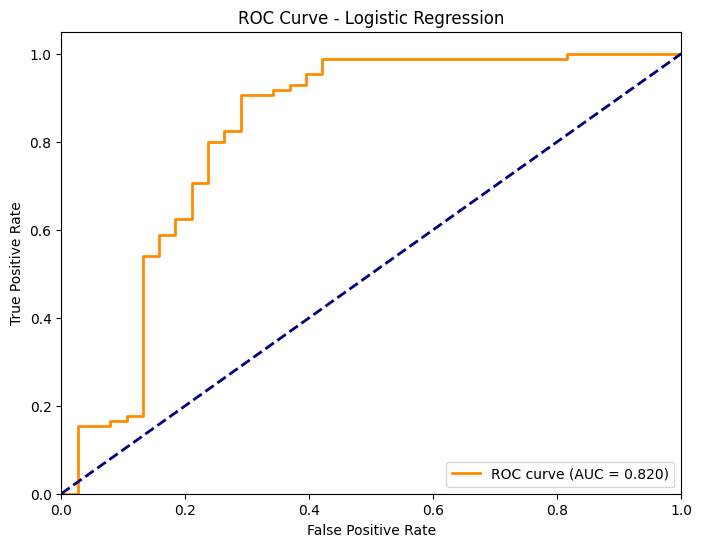

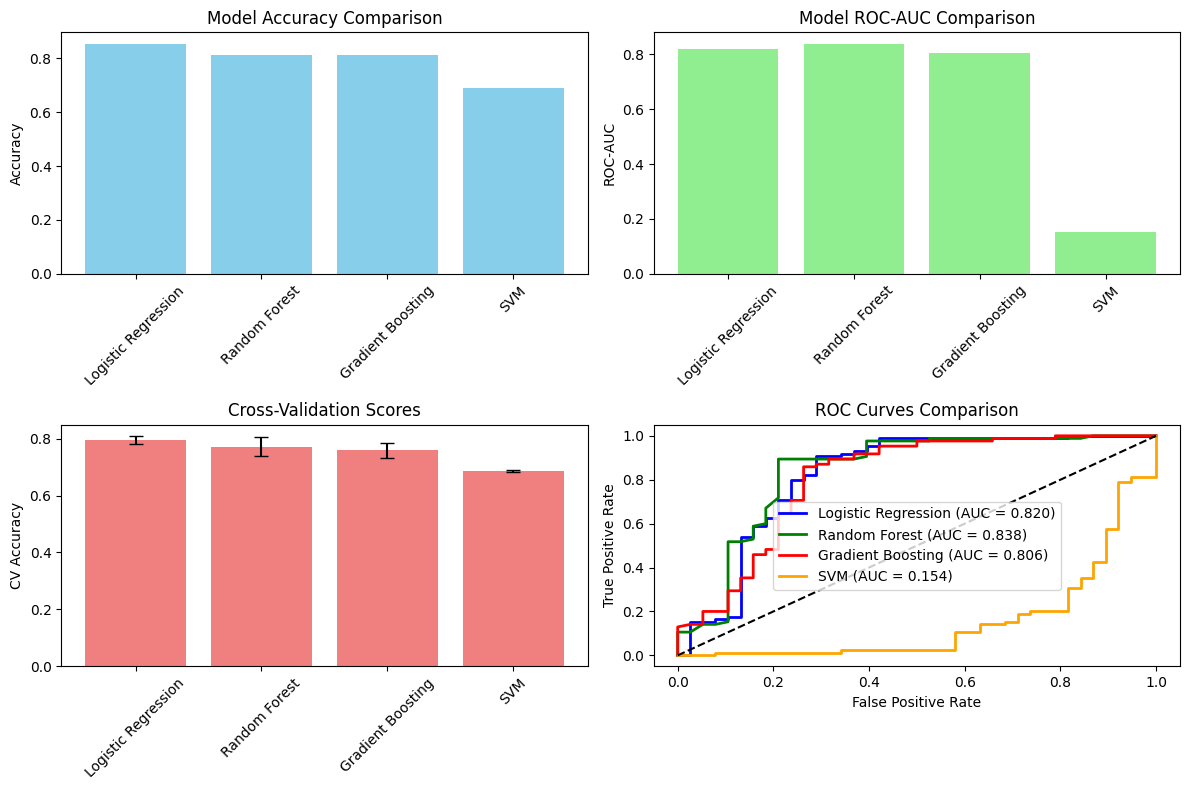


Model comparison summary exported to 'model_results_summary.csv'.


In [6]:
# ================================
# Evaluation of the Best Model
# ================================
print(f"Detailed Evaluation of {best_model_name}")
print("=" * 50)

# Use appropriate input data (scaled vs. raw) based on model type
use_scaled = best_model_name in ['SVM', 'Logistic Regression']
X_test_model = X_test_scaled if use_scaled else X_test

# Predictions
y_pred_best = best_model.predict(X_test_model)
y_pred_proba_best = best_model.predict_proba(X_test_model)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=[str(c) for c in le_target.classes_]))


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.show()

# Feature Importance (Tree-based models only)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Plot top 10 features
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Export feature importance
    feature_importance.to_csv('feature_importance.csv', index=False)
    print("Feature importance saved to 'feature_importance.csv'.")

# ================================
# Model Comparison Visualization
# ================================
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 2, 1)
accuracies = [model_results[m]['accuracy'] for m in model_results]
plt.bar(model_results.keys(), accuracies, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# ROC-AUC
plt.subplot(2, 2, 2)
roc_aucs = [model_results[m]['roc_auc'] for m in model_results]
plt.bar(model_results.keys(), roc_aucs, color='lightgreen')
plt.title('Model ROC-AUC Comparison')
plt.ylabel('ROC-AUC')
plt.xticks(rotation=45)

# CV Scores
plt.subplot(2, 2, 3)
cv_means = [model_results[m]['cv_mean'] for m in model_results]
cv_stds = [model_results[m]['cv_std'] for m in model_results]
plt.bar(model_results.keys(), cv_means, yerr=cv_stds, capsize=5, color='lightcoral')
plt.title('Cross-Validation Scores')
plt.ylabel('CV Accuracy')
plt.xticks(rotation=45)

# ROC Curves
plt.subplot(2, 2, 4)
colors = ['blue', 'green', 'red', 'orange']
for i, (name, results) in enumerate(model_results.items()):
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{name} (AUC = {results["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()

# ================================
# Export Model Results
# ================================
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [res['accuracy'] for res in model_results.values()],
    'ROC-AUC': [res['roc_auc'] for res in model_results.values()],
    'CV Mean': [res['cv_mean'] for res in model_results.values()],
    'CV Std': [res['cv_std'] for res in model_results.values()]
})

results_df.to_csv('model_results_summary.csv', index=False)
print("\nModel comparison summary exported to 'model_results_summary.csv'.")


In [29]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Redefine LoanEligibilityPredictor to match training pipeline
class LoanEligibilityPredictor:
    def __init__(self, model, scaler, label_encoders, feature_columns, model_name="Model"):
        self.model = model
        self.scaler = scaler
        self.label_encoders = label_encoders
        self.feature_columns = feature_columns
        self.model_name = model_name

    def preprocess(self, applicant_data):
        # Convert input to DataFrame
        df = pd.DataFrame([applicant_data])

        # Handle categorical encoding
        for col, le in self.label_encoders.items():
            if col in df.columns:
                df[col + '_encoded'] = le.transform(df[col].astype(str))

        # Feature engineering (matching Cell 3)
        df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
        df['LoanAmountToIncome'] = df['LoanAmount'] / df['TotalIncome']
        df['Dependents_num'] = df['Dependents'].replace('3+', 3).astype(float)
        df['IncomePerDependent'] = df['TotalIncome'] / (df['Dependents_num'] + 1)
        df['ApplicantIncome_log'] = np.log1p(df['ApplicantIncome'])
        df['TotalIncome_log'] = np.log1p(df['TotalIncome'])
        df['LoanAmount_log'] = np.log1p(df['LoanAmount'])

        # Select features in the correct order
        df = df.reindex(columns=self.feature_columns, fill_value=0)

        # Scale only the numerical features
        num_cols_to_scale = [
            'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
            'TotalIncome', 'LoanAmountToIncome', 'IncomePerDependent',
            'ApplicantIncome_log', 'TotalIncome_log', 'LoanAmount_log'
        ]
        num_indices = [self.feature_columns.index(col) for col in num_cols_to_scale]
        df_scaled = df.copy()
        df_scaled.iloc[:, num_indices] = self.scaler.transform(df.iloc[:, num_indices])

        return df_scaled

    def predict(self, applicant_data):
        try:
            X_processed = self.preprocess(applicant_data)
            prediction = self.model.predict(X_processed)[0]
            proba = self.model.predict_proba(X_processed)[0]
            return {
                "Loan_ID": applicant_data.get("Loan_ID", "Unknown"),
                "status": "✅ Approved" if prediction == 1 else "❌ Rejected",
                "probability_approved": round(proba[1] * 100, 2),  # Convert to percentage
                "probability_rejected": round(proba[0] * 100, 2)  # Convert to percentage
            }
        except Exception as e:
            return {
                "Loan_ID": applicant_data.get("Loan_ID", "Unknown"),
                "status": "⚠️ Prediction Failed",
                "probability_approved": None,
                "probability_rejected": None,
                "error": str(e)
            }

# Load dataset
loan_data = pd.read_csv('loan.csv')

# Drop rows with missing values in important columns
required_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
                'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
                'Credit_History', 'Property_Area']
filtered_data = loan_data.dropna(subset=required_cols).copy()

# Report dropped rows
dropped_rows = len(loan_data) - len(filtered_data)
print(f"\nTotal rows in loan.csv: {len(loan_data)}")
print(f"Rows after dropping missing values: {len(filtered_data)}")
print(f"Rows dropped due to missing values: {dropped_rows}")

# Use all rows in filtered_data for prediction
test_samples = filtered_data

# Load the model package
try:
    model_package = joblib.load('loan_eligibility_model_logistic_regression.pkl')
except FileNotFoundError:
    print("Error: 'loan_eligibility_model_logistic_regression.pkl' not found. Please run Cell 8 to generate the model file.")
    raise

# Instantiate the predictor
predictor = LoanEligibilityPredictor(
    model=model_package['model'],
    scaler=model_package['scaler'],
    label_encoders=model_package['label_encoders'],
    feature_columns=model_package['feature_columns'],
    model_name=model_package['model_name']
)

print("\nTesting Predictions on All Samples from Dataset")
print("=" * 60)

# Collect data for table
table_data = []
for idx, row in test_samples.iterrows():
    # Include Loan_ID in the application dictionary
    application = row.drop(labels=['Loan_Status'], errors='ignore').to_dict()

    # Use sample number as index
    sample_num = idx

    # Get prediction
    result = predictor.predict(application)

    # Combine application details and prediction
    table_row = {
        'Sample': sample_num,
        'Loan_ID': result['Loan_ID'],
        'Gender': application['Gender'],
        'Married': application['Married'],
        'Dependents': application['Dependents'],
        'Education': application['Education'],
        'Self_Employed': application['Self_Employed'],
        'ApplicantIncome': application['ApplicantIncome'],
        'CoapplicantIncome': application['CoapplicantIncome'],
        'LoanAmount': application['LoanAmount'],
        'Loan_Amount_Term': application['Loan_Amount_Term'],
        'Credit_History': application['Credit_History'],
        'Property_Area': application['Property_Area'],
        'Status': result['status'],
        'Probability_Approved (%)': result['probability_approved'],
        'Probability_Rejected (%)': result['probability_rejected']
    }
    table_data.append(table_row)

# Create DataFrame for table display
table_df = pd.DataFrame(table_data)

# Display table
print(table_df.to_string(index=False))


Total rows in loan.csv: 614
Rows after dropping missing values: 480
Rows dropped due to missing values: 134

Testing Predictions on All Samples from Dataset
 Sample  Loan_ID Gender Married Dependents    Education Self_Employed  ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History Property_Area     Status  Probability_Approved (%)  Probability_Rejected (%)
      1 LP001003   Male     Yes          1     Graduate            No             4583        1508.000000       128.0             360.0             1.0         Rural ✅ Approved                     85.42                     14.58
      2 LP001005   Male     Yes          0     Graduate           Yes             3000           0.000000        66.0             360.0             1.0         Urban ✅ Approved                     79.11                     20.89
      3 LP001006   Male     Yes          0 Not Graduate            No             2583        2358.000000       120.0             360.0             1.0    

In [30]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# Load dataset
loan_data = pd.read_csv('loan.csv')

# Define required columns
required_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
                'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
                'Credit_History', 'Property_Area']
target_col = 'Loan_Status'

# Drop rows with missing values in required columns or target
filtered_data = loan_data.dropna()

# Encode target variable
le_target = LabelEncoder()
filtered_data['Loan_Status'] = le_target.fit_transform(filtered_data['Loan_Status'])  # Y -> 1, N -> 0

# Feature Engineering
filtered_data['TotalIncome'] = filtered_data['ApplicantIncome'] + filtered_data['CoapplicantIncome']
filtered_data['LoanAmountToIncome'] = filtered_data['LoanAmount'] / filtered_data['TotalIncome']
filtered_data['Dependents_num'] = filtered_data['Dependents'].replace('3+', 3).astype(float)
filtered_data['IncomePerDependent'] = filtered_data['TotalIncome'] / (filtered_data['Dependents_num'] + 1)
filtered_data['ApplicantIncome_log'] = np.log1p(filtered_data['ApplicantIncome'])
filtered_data['TotalIncome_log'] = np.log1p(filtered_data['TotalIncome'])
filtered_data['LoanAmount_log'] = np.log1p(filtered_data['LoanAmount'])

# Encode categorical variables
label_encoders = {}
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
for col in categorical_cols:
    le = LabelEncoder()
    filtered_data[col + '_encoded'] = le.fit_transform(filtered_data[col].astype(str))
    label_encoders[col] = le

# Define feature columns
feature_columns = [
    'Gender_encoded', 'Married_encoded', 'Dependents_num', 'Education_encoded',
    'Self_Employed_encoded', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
    'Loan_Amount_Term', 'Credit_History', 'Property_Area_encoded',
    'TotalIncome', 'LoanAmountToIncome', 'IncomePerDependent',
    'ApplicantIncome_log', 'TotalIncome_log', 'LoanAmount_log'
]

# Prepare features and target
X = filtered_data[feature_columns]
y = filtered_data['Loan_Status']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
num_cols_to_scale = [
    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
    'TotalIncome', 'LoanAmountToIncome', 'IncomePerDependent',
    'ApplicantIncome_log', 'TotalIncome_log', 'LoanAmount_log'
]
scaler = StandardScaler()
num_indices = [feature_columns.index(col) for col in num_cols_to_scale]
X_train_scaled = X_train.copy()
X_train_scaled.iloc[:, num_indices] = scaler.fit_transform(X_train.iloc[:, num_indices])
X_test_scaled = X_test.copy()
X_test_scaled.iloc[:, num_indices] = scaler.transform(X_test.iloc[:, num_indices])

# Train model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Save model package
model_package = {
    'model': model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'model_name': 'Logistic Regression'
}
joblib.dump(model_package, 'loan_eligibility_model_logistic_regression.pkl')

print("Model saved as 'loan_eligibility_model_logistic_regression.pkl'")

Model saved as 'loan_eligibility_model_logistic_regression.pkl'
